### **Librerias**

In [ ]:
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Librería para diseñar y entrenar redes neuronales convolucionales
import tensorflow as tf
print('TensorFlow version: {}'.format(tf.__version__))
tf.random.set_seed(64)

# Manejo de matrices
import numpy as np

# Visualización y gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.layers import Input,Conv1D,MaxPooling1D,Dense,Flatten,Dropout,Reshape,UpSampling2D,Conv2D
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from numpy import unique
from keras.models import Model

# Libreria para trabajar con imágenes
import cv2

from tensorflow import squeeze
from tensorflow import reduce_mean
from tensorflow.keras.models import load_model


import datetime

%load_ext tensorboard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.metrics import F1Score


import os
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import fashion_mnist

#rm -rf ./logs/

TensorFlow version: 2.13.0


## **POINT 1**

The base architecture to pre-train and train the created models is MobilenetV2, you can find more information in [the original article](https://arxiv.org/abs/1801.04381)

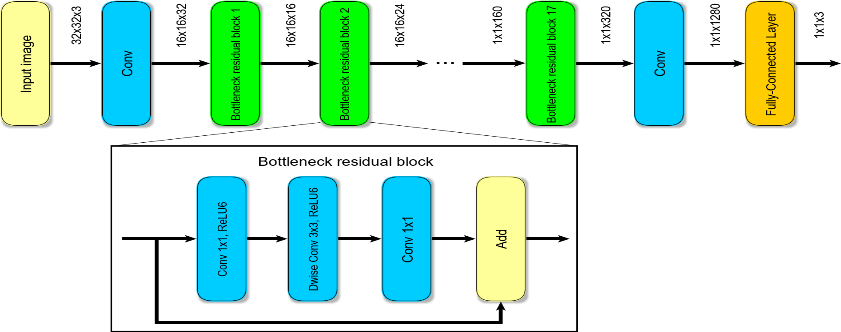

### CREACIÓN Y ENTRENAMIENTO DEL MODELO PARA PREENTRENAMIENTO

### **Train model for dowload weigths**

In [ ]:
mnist_fashion = fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_fashion.load_data()

train_images = train_images.reshape((60000, 28, 28,1))
test_images = test_images.reshape((10000, 28, 28,1))

4422102/4422102 [==============================] - 0s 0us/step


In [ ]:
def pre_mobilenet_v2(paramet_train):

  base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False, input_shape = (224,224,3))

  total_layers = len(base_model.layers)
  div_layers = total_layers// 3
  bol_simple = False

  if paramet_train == 'I':
    trains_layers = base_model.layers[0:div_layers]
    inf = 'initial'

  elif paramet_train == 'M':
    trains_layers = base_model.layers[div_layers:div_layers*2]
    inf = 'middle'

  elif paramet_train == 'F':
    trains_layers = base_model.layers[div_layers*2:-1]
    inf = 'final'

  elif paramet_train == 'A': #if i wanna that nothign train
    trains_layers = base_model.layers[:]
    inf = 'alls'
    bol_simple = True

  elif paramet_train == 'N':#if i wanna that ALLS train
    trains_layers = base_model.layers[:]
    inf = 'nothing'
    bol_simple = True


  print('The total weights of MobilenetV2 are {} and you are going to train the weights of the {} '.format(total_layers,inf))
  for layer in trains_layers:
    layer.trainable = False or bol_simple



  return base_model


In [ ]:
def pre_model(n_classes,input_shape,paramet_train,to_concat:bool):

  input = Input(input_shape)

  x = Conv2D(filters=3, kernel_size=(3,3), padding='same')(input)
  x = UpSampling2D(size=(8, 8))(x)
  pre_model_ = pre_mobilenet_v2(paramet_train)(x)

  if to_concat:
    model = Flatten()(pre_model_)

  else:
    x = Flatten()(pre_model_)
    output = Dense(n_classes, activation='softmax')(x)
    model = Model(input, output)
    model.summary()

  return model

In [ ]:
def comp_mode(model):
  model.compile(optimizer=tf.keras.optimizers.Lion(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

In [ ]:
EPOCHS = 10
checkpoint_filepath = '/content/drive/MyDrive/DOCTORADO/MATERIAS/SEMESTRE_2/DEEP_LEARNING/TAREA_2/pre_train_model_fashion_mnist/move_all_weigths'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model_pre_ = pre_model()
model_pre_ = comp_mode(model_pre_)
model_pre_.fit(train_images, train_labels, validation_split=0.4,epochs=EPOCHS, callbacks=[model_checkpoint_callback],batch_size=20)

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 3)         30        
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                

The weights were stored in the url =
/content/drive/MyDrive/DOCTORADO/MATERIAS/SEMESTRE_2/DEEP_LEARNING/TAREA_2/pre_train_model_fashion_mnist/move_all_weigths

### **Train model for dowload weigths**

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 3)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 3)
x_test=x_test / 255.0

y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

In this section we will load the already trained weights and test the new model in 3 scenarios:
leaving the first weights untrainable

1.   leaving the initial weights untrainable
2.   leaving the middle weights untrainable
3.   leaving the final weights untrainable


In [ ]:
#It was necessary to train the models in different Google accounts since we did not have Google Colab Pro or Pro +
root_path = '/content/drive/MyDrive/DOCTORADO/TAREA_2'
path_weigths_pre_train = root_path +'/pre_train_model_fashion_mnist/move_all_weigths'

I_W_U_check_points = root_path + '/train_models_cifar_point_1/I_W_U/check_point'
logs_fit_I_W_U = root_path + '/train_models_cifar_point_1/I_W_U/logs/fit'

M_W_U_check_points = root_path + '/train_models_cifar_point_1/M_W_U/check_point'
logs_fit_M_W_U = root_path + '/train_models_cifar_point_1/M_W_U/logs/fit'

F_W_U_check_points = root_path + '/train_models_cifar_point_1/F_W_U/check_point'
logs_fit_F_W_U = root_path + '/train_models_cifar_point_1/F_W_U/logs/fit'


Initial weights untrainable

In [ ]:
pre_model_initial = pre_model(10,input_shape=(28,28,1),paramet_train='I',to_concat=False)

The total weights of MobilenetV2 are 154 and you are going to train the weights of the initial 
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 3)         30        
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 224, 224, 3)       0         
 g2D)                                                            
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                             

In [ ]:
pre_model_initial.load_weights(path_weigths_pre_train)

In [ ]:
def I_W_U_model(pre_model):
  input = Input((32,32,3))

  x = Conv2D(filters=1, kernel_size=(5,5), padding='valid')(input)

  x = pre_model(x)

  output =Reshape((1,x.shape[1]))(x)
  model = Model(input,output,name='Model_initial_wei_no_trai')
  model.summary()

  return model

In [ ]:
I_W_U_mode_ = I_W_U_model(pre_model_initial)

Model: "Model_initial_wei_no_trai"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         76        
                                                                 
 model (Functional)          (None, 10)                2885224   
                                                                 
 reshape (Reshape)           (None, 1, 10)             0         
                                                                 
Total params: 2885300 (11.01 MB)
Trainable params: 2801908 (10.69 MB)
Non-trainable params: 83392 (325.75 KB)
_________________________________________________________________


In [ ]:
I_W_U_mode_.load_weights('/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/I_W_U/check_point')

In [ ]:
I_W_U_mode_ = comp_mode(I_W_U_mode_)

In [ ]:
#check paths  "filepath" and "log_dir"
EPOCHS = 10
model_checkpoint_callback = ModelCheckpoint(
    filepath= I_W_U_check_points ,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

tensorboard_callback = TensorBoard(log_dir = logs_fit_I_W_U + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

In [ ]:
I_W_U_mode_.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=EPOCHS,callbacks=[model_checkpoint_callback,tensorboard_callback],batch_size=4)

Epoch 1/10
12500/12500 [==============================] - 376s 28ms/step - loss: 2.2570 - accuracy: 0.2628 - val_loss: 3.7208 - val_accuracy: 0.3177
Epoch 2/10
12500/12500 [==============================] - 344s 28ms/step - loss: 1.5593 - accuracy: 0.4339 - val_loss: 1.4339 - val_accuracy: 0.4880
Epoch 3/10
12500/12500 [==============================] - 350s 28ms/step - loss: 1.3481 - accuracy: 0.5123 - val_loss: 1.4974 - val_accuracy: 0.4699
Epoch 4/10
12500/12500 [==============================] - 346s 28ms/step - loss: 1.2110 - accuracy: 0.5661 - val_loss: 1.6793 - val_accuracy: 0.4973
Epoch 5/10
12500/12500 [==============================] - 342s 27ms/step - loss: 1.1202 - accuracy: 0.6034 - val_loss: 5.0207 - val_accuracy: 0.2428
Epoch 6/10
12500/12500 [==============================] - 345s 28ms/step - loss: 1.0975 - accuracy: 0.6090 - val_loss: 1.2330 - val_accuracy: 0.6001
Epoch 7/10
12500/12500 [==============================] - 343s 27ms/step - loss: 1.0000 - accuracy: 0.6440

Middle weights untrainable

In [ ]:
pre_model_middle = pre_model(10,input_shape=(28,28,1),paramet_train='M',to_concat=False)

The total weights of MobilenetV2 are 154 and you are going to train the weights of the middle 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 3)         30        
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                

In [ ]:
pre_model_middle.load_weights(path_weigths_pre_train)

In [ ]:
def M_W_U_model(pre_model):
  input = Input((32,32,3))

  x = Conv2D(filters=1, kernel_size=(5,5), padding='valid')(input)

  x = pre_model(x)

  output =Reshape((1,x.shape[1]))(x)
  model = Model(input,output,name = 'Model_middle_wei_no_trai')
  model.summary()

  return model

In [ ]:
M_W_U_mode_ = M_W_U_model(pre_model_initial)

Model: "Model_middle_wei_no_trai"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 1)         76        
                                                                 
 model (Functional)          (None, 10)                2885224   
                                                                 
 reshape_1 (Reshape)         (None, 1, 10)             0         
                                                                 
Total params: 2885300 (11.01 MB)
Trainable params: 2801908 (10.69 MB)
Non-trainable params: 83392 (325.75 KB)
_________________________________________________________________


In [ ]:
#check paths  "filepath" and "log_dir"
EPOCHS = 10
model_checkpoint_callback = ModelCheckpoint(
    filepath= M_W_U_check_points ,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

tensorboard_callback = TensorBoard(log_dir = logs_fit_M_W_U + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

In [ ]:
M_W_U_mode_.load_weights('/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/M_W_U/check_point')

In [ ]:
M_W_U_mode_ = comp_mode(M_W_U_mode_)

In [ ]:
M_W_U_mode_.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=EPOCHS,callbacks=[model_checkpoint_callback,tensorboard_callback],batch_size=4)#, callbacks=[model_checkpoint_callback]

Epoch 1/10
12500/12500 [==============================] - 375s 29ms/step - loss: 0.9419 - accuracy: 0.6690 - val_loss: 1.0388 - val_accuracy: 0.6415
Epoch 2/10
12500/12500 [==============================] - 361s 29ms/step - loss: 0.7924 - accuracy: 0.7211 - val_loss: 0.8901 - val_accuracy: 0.6935
Epoch 3/10
12500/12500 [==============================] - 356s 28ms/step - loss: 0.7391 - accuracy: 0.7387 - val_loss: 1.0438 - val_accuracy: 0.6586
Epoch 4/10
12500/12500 [==============================] - 354s 28ms/step - loss: 0.6900 - accuracy: 0.7555 - val_loss: 0.9780 - val_accuracy: 0.6871
Epoch 5/10
12500/12500 [==============================] - 354s 28ms/step - loss: 0.6497 - accuracy: 0.7705 - val_loss: 1.0157 - val_accuracy: 0.6954
Epoch 6/10
12500/12500 [==============================] - 356s 28ms/step - loss: 0.6365 - accuracy: 0.7760 - val_loss: 0.9459 - val_accuracy: 0.7075
Epoch 7/10
12500/12500 [==============================] - 360s 29ms/step - loss: 0.5965 - accuracy: 0.7877

Final weights untrainable

In [ ]:
pre_model_final = pre_model(10,input_shape=(28,28,1),paramet_train='F',to_concat=False)

9406464/9406464 [==============================] - 1s 0us/step
The total weights of MobilenetV2 are 154 and you are going to train the weights of the final 
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 3)         30        
                                                                 
 up_sampling2d (UpSampling2  (None, 224, 224, 3)       0         
 D)                                                              
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten (Flatten)           (None, 

In [ ]:
pre_model_final.load_weights(path_weigths_pre_train)

In [ ]:
def F_W_U_model(pre_model):
  input = Input((32,32,3))

  x = Conv2D(filters=1, kernel_size=(5,5), padding='valid')(input)

  x = pre_model(x)

  output =Reshape((1,x.shape[1]))(x)
  model = Model(input,output,name = 'Model_final_wei_no_trai')
  model.summary()

  return model

In [ ]:
F_W_U_mode_ = F_W_U_model(pre_model_final)

Model: "Model_final_wei_no_trai"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 1)         76        
                                                                 
 model (Functional)          (None, 10)                2885224   
                                                                 
 reshape (Reshape)           (None, 1, 10)             0         
                                                                 
Total params: 2885300 (11.01 MB)
Trainable params: 994932 (3.80 MB)
Non-trainable params: 1890368 (7.21 MB)
_________________________________________________________________


In [ ]:
F_W_U_mode_.load_weights('/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/F_W_U/check_point')

In [ ]:
#check paths  "filepath" and "log_dir"
EPOCHS = 10
model_checkpoint_callback = ModelCheckpoint(
    filepath= F_W_U_check_points ,
    monitor='accuracy',
    mode='max',
    save_best_only=True)

tensorboard_callback = TensorBoard(log_dir = logs_fit_F_W_U + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

In [ ]:
F_W_U_mode_ = comp_mode(F_W_U_mode_)

In [ ]:
F_W_U_mode_.fit(x_train, y_train, validation_data=(x_test, y_test),epochs=EPOCHS,callbacks=[tensorboard_callback, model_checkpoint_callback],batch_size=4)

Epoch 1/10
12500/12500 [==============================] - 366s 28ms/step - loss: 0.7723 - accuracy: 0.7293 - val_loss: 0.8334 - val_accuracy: 0.7160
Epoch 2/10
12500/12500 [==============================] - 358s 29ms/step - loss: 0.6373 - accuracy: 0.7751 - val_loss: 0.9067 - val_accuracy: 0.7303
Epoch 3/10
12500/12500 [==============================] - 361s 29ms/step - loss: 0.5814 - accuracy: 0.7953 - val_loss: 0.9369 - val_accuracy: 0.6971
Epoch 4/10
12500/12500 [==============================] - 357s 29ms/step - loss: 0.5375 - accuracy: 0.8091 - val_loss: 0.8674 - val_accuracy: 0.7397
Epoch 5/10
12500/12500 [==============================] - 361s 29ms/step - loss: 0.5121 - accuracy: 0.8175 - val_loss: 1.1332 - val_accuracy: 0.7071
Epoch 6/10
12500/12500 [==============================] - 351s 28ms/step - loss: 0.4802 - accuracy: 0.8315 - val_loss: 0.8574 - val_accuracy: 0.7316
Epoch 7/10
12500/12500 [==============================] - 366s 29ms/step - loss: 0.4436 - accuracy: 0.8422

Note: It is important to select a better batch size according to [Deep learning](https://www.deeplearningbook.org/contents/optimization.html)

Comparative of models

In [ ]:
log_new_F_W_U = '/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/F_W_U/logs/fit20230924-180226'
log_new_M_W_U = '/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/M_W_U/logs/fit20230924-165915'
log_new_I_W_U =  '/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/I_W_U/logs/fit20230924-160011'
%tensorboard --logdir_spec =log_new_F_W_U,log_new_I_W_U,log_new_M_W_U

In [ ]:
y_pred_I = I_W_U_mode_.predict(x_test)
y_pred_M = M_W_U_mode_.predict(x_test)
y_pred_F = F_W_U_mode_.predict(x_test)

313/313 [==============================] - 560s 2s/step


In [ ]:
y_test_S = squeeze(y_test, axis=1)
y_pred_I_S = squeeze(y_pred_I, axis=1)
y_pred_M_S = squeeze(y_pred_M, axis=1)
y_pred_F_S = squeeze(y_pred_F, axis=1)

*F1 Score*

In [ ]:
F1_05 = F1Score(threshold=0.5)

In [ ]:
F1_05.update_state(y_test_S,y_pred_I_S)
print('F1_SCORE To model of initial weights no train')
print('\n ')
print('The F1_SCORE for class are: {}'.format(F1_05.result()))
print('\n ')
print('The F1_SCORE global are: {}'.format(reduce_mean(F1_05.result())))

F1_SCORE To model of initial weights no train

 
The F1_SCORE for class are: [0.7435523  0.8327098  0.5546218  0.5126175  0.52393985 0.6066116
 0.7557557  0.72509956 0.7988539  0.79571986]

 
The F1_SCORE global are: 0.6849482655525208


In [ ]:
F1_05.update_state(y_test_S,y_pred_M_S)
print('F1_SCORE To model of middle weights no train')
print('\n ')
print('The F1_SCORE for class are: {}'.format(F1_05.result()))
print('\n ')
print('The F1_SCORE global are: {}'.format(reduce_mean(F1_05.result())))

F1_SCORE To model of middle weights no train

 
The F1_SCORE for class are: [0.7410038  0.83100855 0.54476523 0.50779283 0.51438475 0.60205585
 0.7485585  0.7184801  0.7997718  0.80792373]

 
The F1_SCORE global are: 0.6815745234489441


In [ ]:
F1_05.update_state(y_test_S,y_pred_F_S)
print('F1_SCORE To model of finally weights no train')
print('\n ')
print('The F1_SCORE for class are: {}'.format(F1_05.result()))
print('\n ')
print('The F1_SCORE global are: {}'.format(reduce_mean(F1_05.result())))

F1_SCORE To model of finally weights no train

 
The F1_SCORE for class are: [0.74766946 0.8401989  0.5692484  0.52275425 0.55413586 0.6151433
 0.766756   0.73282444 0.80618984 0.81798357]

 
The F1_SCORE global are: 0.6972904205322266


*Recall*

In [ ]:
from tensorflow.keras.metrics import Recall

In [ ]:
recall_metric = Recall()

In [ ]:
recall_metric.update_state(y_test_S,y_pred_I_S)
print('RECALL To model of initial weights no train')
print('\n ')
print('The RECALL global are: {}'.format(reduce_mean(recall_metric.result())))

RECALL To model of initial weights no train

 
The RECALL global are: 0.6622750163078308


In [ ]:
recall_metric.update_state(y_test_S,y_pred_M_S)
print('RECALL To model of middle weights no train')
print('\n ')
print('The RECALL global are: {}'.format(reduce_mean(recall_metric.result())))

RECALL To model of middle weights no train

 
The RECALL global are: 0.6586599946022034


In [ ]:
recall_metric.update_state(y_test_S,y_pred_F_S)
print('RECALL To model of finally weights no train')
print('\n ')
print('The RECALL global are: {}'.format(reduce_mean(recall_metric.result())))

RECALL To model of finally weights no train

 
The RECALL global are: 0.6691856980323792


*Precision*

In [ ]:
from tensorflow.keras.metrics import Precision

In [ ]:
precision_metric = Precision()

In [ ]:
precision_metric.update_state(y_test_S,y_pred_I_S)
print('PRECISION To model of initial weights no train')
print('\n ')
print('The PRECISION  global are: {}'.format(reduce_mean(precision_metric.result())))

PRECISION To model of initial weights no train

 
The PRECISION  global are: 0.7233454585075378


In [ ]:
precision_metric.update_state(y_test_S,y_pred_M_S)
print('PRECISION To model of middle weights no train')
print('\n ')
print('The PRECISION global are: {}'.format(reduce_mean(precision_metric.result())))

PRECISION To model of middle weights no train

 
The PRECISION global are: 0.7228962779045105


In [ ]:
precision_metric.update_state(y_test_S,y_pred_F_S)
print('PRECISION To model of finally weights no train')
print('\n ')
print('The PRECISION  global are: {}'.format(reduce_mean(precision_metric.result())))

PRECISION To model of finally weights no train

 
The PRECISION  global are: 0.7371377944946289


*Confusion Matrix*

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
labels_cifar = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

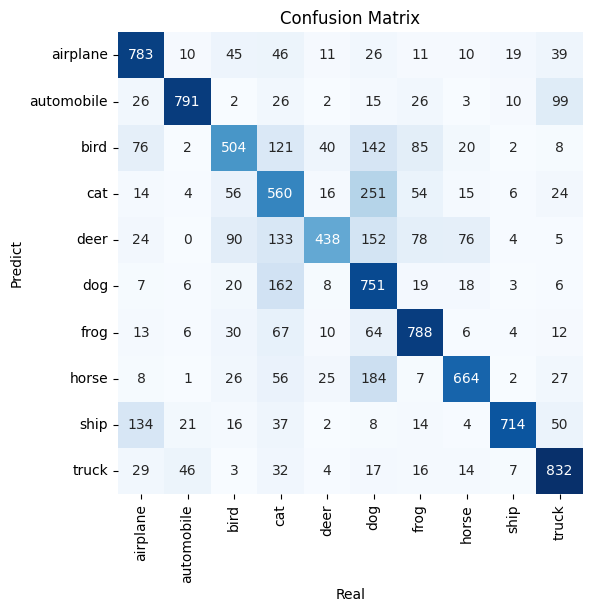

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix(np.argmax(y_test_S, axis=1), np.argmax(y_pred_I_S, axis=1)),xticklabels=labels_cifar, yticklabels=labels_cifar,annot=True, cmap='Blues', cbar=False, fmt='g',)
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion Matrix')
plt.show()

*Report*

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print('Report of To model of initial weights no train')
print(classification_report(np.argmax(y_test_S, axis=1), np.argmax(y_pred_I_S, axis=1)))

Report of To model of initial weights no train
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1000
           1       0.89      0.79      0.84      1000
           2       0.64      0.50      0.56      1000
           3       0.45      0.56      0.50      1000
           4       0.79      0.44      0.56      1000
           5       0.47      0.75      0.58      1000
           6       0.72      0.79      0.75      1000
           7       0.80      0.66      0.73      1000
           8       0.93      0.71      0.81      1000
           9       0.75      0.83      0.79      1000

    accuracy                           0.68     10000
   macro avg       0.71      0.68      0.69     10000
weighted avg       0.71      0.68      0.69     10000



In [ ]:
print('Report of To model of middle weights no train')
print(classification_report(np.argmax(y_test_S, axis=1), np.argmax(y_pred_M_S, axis=1)))

Report of To model of middle weights no train
              precision    recall  f1-score   support

           0       0.65      0.82      0.72      1000
           1       0.89      0.78      0.83      1000
           2       0.57      0.53      0.55      1000
           3       0.46      0.54      0.50      1000
           4       0.79      0.43      0.56      1000
           5       0.47      0.73      0.57      1000
           6       0.71      0.77      0.74      1000
           7       0.81      0.65      0.72      1000
           8       0.91      0.72      0.80      1000
           9       0.83      0.81      0.82      1000

    accuracy                           0.68     10000
   macro avg       0.71      0.68      0.68     10000
weighted avg       0.71      0.68      0.68     10000



In [ ]:
print('Report of To model of finally weights no train')
print(classification_report(np.argmax(y_test_S, axis=1), np.argmax(y_pred_F_S, axis=1)))

Report of To model of finally weights no train
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1000
           1       0.90      0.83      0.86      1000
           2       0.64      0.61      0.62      1000
           3       0.52      0.59      0.55      1000
           4       0.83      0.55      0.66      1000
           5       0.53      0.75      0.63      1000
           6       0.77      0.81      0.79      1000
           7       0.86      0.69      0.77      1000
           8       0.91      0.75      0.83      1000
           9       0.82      0.84      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000



CONCLUTION


  \begin{array}{|c|c|c|c|c|}
  \hline\\
  \mathcal{} & \mathcal{RECALL} & \mathcal{PRECISSION} & \mathcal{F1_SCORE}\\
  \hline\\
  {Model_{I.W.N.T}}  & 0.662 & 0.723 & 0.684  
  \\ \hline\\
  {Model_{M.W.N.T}}  & 0.658 & 0.722 & 0.681
  \\ \hline\\
  {Model_{F.W.N.T}} & 0.669 & 0.737 & 0.697   
  \\ \hline \end{array}

According to the analysis carried out, the model with the **untrained final weights** is selected as the model to be used in the second point.

## **POINT 2**

### CREATE NEW MODEL 0

The architecture selected for this second point is ShuffleNet, you can find more information in the original article [the original article](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_ShuffleNet_An_Extremely_CVPR_2018_paper.pdf).

The architecture is adapted from the [repository](https://github.com/Haikoitoh/paper-implementation)

In [ ]:
#MODIFICATION AND ADD SQUEEZEE AND CBUM BLOCK TO IMPROVE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add,AveragePooling2D,Dense, AvgPool2D,BatchNormalization, ReLU, DepthwiseConv2D, Reshape, Permute,Conv2D, MaxPool2D, GlobalAveragePooling2D, concatenate

In [ ]:
def channel_shuffle(x, groups):
    _, width, height, channels = x.get_shape().as_list()
    group_ch = channels // groups

    x = Reshape([width, height, group_ch, groups])(x)
    x = Permute([1, 2, 4, 3])(x)
    x = Reshape([width, height, channels])(x)
    return x

In [ ]:
def shuffle_unit(x, groups, channels,strides):

    y = x
    x = Conv2D(channels//4, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = channel_shuffle(x, groups)

    x = DepthwiseConv2D(kernel_size = (3,3), strides = strides, padding = 'same')(x)
    x = BatchNormalization()(x)

    if strides == (2,2):
        channels = channels - y.shape[-1]
    x = Conv2D(channels, kernel_size = 1, strides = (1,1),padding = 'same', groups=groups)(x)
    x = BatchNormalization()(x)

    if strides ==(1,1):
        x =Add()([x,y])
    if strides == (2,2):
        y = AvgPool2D((3,3), strides = (2,2), padding = 'same')(y)
        x = concatenate([x,y])

    x = ReLU()(x)


    return x

In [ ]:
def Shuffle_Net(nclasses, start_channels ,input_shape,to_concat:bool):

    groups = 2
    input = Input (input_shape)

    x =  Conv2D (24,kernel_size=3,strides = (2,2), padding = 'same', use_bias = True)(input)
    x =  BatchNormalization()(x)
    x =  ReLU()(x)

    x = MaxPool2D (pool_size=(3,3), strides = 2, padding='same')(x)

    repetitions = [3,7,3]

    for i,repetition in enumerate(repetitions):
        channels = start_channels * (2**i)

        x  = shuffle_unit(x, groups, channels,strides = (2,2))

        for i in range(repetition):
            x = shuffle_unit(x, groups, channels,strides=(1,1))


    if to_concat:
      x = GlobalAveragePooling2D(name='conv_to_3_point')(x)
      x = Flatten()(x)
      model = Dense(20, activation='relu')(x)


    else:
      x = GlobalAveragePooling2D()(x)


      output = Dense(n_classes,activation='softmax')(x)
      model = Model(input, output)
      model.summary()


    return model,input

In [ ]:
n_classes = 10
input_shape = (32,32,3)
start_channels = 200

model_Shuffle_Net, input_Shuffle_Net = Shuffle_Net(n_classes, start_channels,input_shape,to_concat=True)


### CREATE NEW MODEL 1

In [ ]:
pre_model_final = pre_model(10,input_shape=(28,28,1),paramet_train='F',to_concat=False)
pre_model_final.load_weights(path_weigths_pre_train)
F_W_U_mode_1 = F_W_U_model(pre_model_final)
F_W_U_mode_1.load_weights('/content/drive/MyDrive/DOCTORADO/TAREA_2/train_models_cifar_point_1/F_W_U/check_point')

In [ ]:
model_extra = F_W_U_mode_1.layers[1:3]
layer_1 = model_extra[0]
layer_2 = model_extra[1]

input__pre_train = Input((32,32,3))
x = layer_1(input__pre_train)
x = layer_2(x)
x = Flatten()(x)
out_put_pre_train = Dense(20, activation='relu')(x)



### CREATE NEW MODEL 2

In [ ]:
def conv1D_model(n_classes,input_shape,to_concat:bool):

  input = Input(input_shape)

  x = Flatten()(input)
  x = Reshape((x.shape[1],1))(x)
  x = Conv1D(filters=64, kernel_size=8,strides=1, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Conv1D(filters=32, kernel_size=4,strides=1, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Conv1D(filters=16, kernel_size=2,strides=1, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = MaxPooling1D(pool_size=2, name="MaxPooling1D")(x)

  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(150, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(20, activation='relu')(x)

  if to_concat :
    model = x

  else:
    x = Dense(n_classes,activation='softmax')(x)
    output = Reshape((1,x.shape[1]))(x)
    model = Model(input, output)
    model.summary()

  return model,input



In [ ]:
mode_conv1d,intput_conv1d  = conv1D_model(n_classes=10,input_shape=(32,32,3),to_concat = True)

### CONCATENATE

In [ ]:
multimodal_out_put = tf.keras.layers.concatenate([model_Shuffle_Net, mode_conv1d,out_put_pre_train])
multimodal_out_put = tf.keras.layers.Dense(10, activation='softmax', name='output')(multimodal_out_put)
multimodal_out_put = Reshape((1,multimodal_out_put.shape[1]))(multimodal_out_put)

In [ ]:
Model_multimodal = Model(inputs=[input_Shuffle_Net,intput_conv1d , input__pre_train ], outputs=multimodal_out_put)

In [ ]:
Model_multimodal.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 24)           672       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 24)           96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 24)           0         ['batch_normalization[0]

In [ ]:
from tensorflow.keras.utils import plot_model

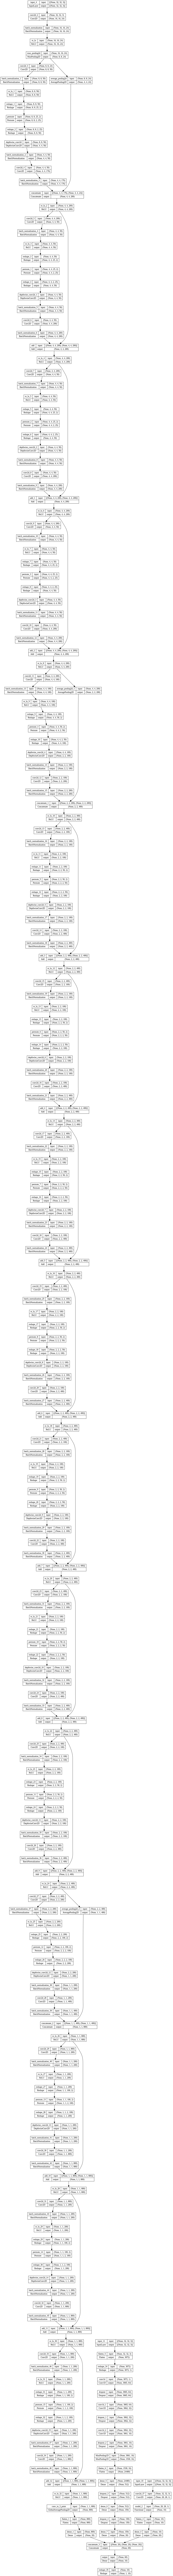

In [ ]:
plot_model(Model_multimodal, show_shapes=True)

In [ ]:
Model_multimodal = comp_mode(Model_multimodal)

In [ ]:
EPOCHS = 5
model_checkpoint_callback = ModelCheckpoint(
    filepath= '/content/drive/MyDrive/DOCTORADO/TAREA_2/multimodal_model/model_saves',
    monitor='accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
Model_multimodal.fit([x_train,x_train,x_train], y_train,epochs=EPOCHS,batch_size=4)

Epoch 1/5
12500/12500 [==============================] - 842s 64ms/step - loss: 1.0144 - accuracy: 0.7194
Epoch 2/5
12500/12500 [==============================] - 762s 61ms/step - loss: 0.5807 - accuracy: 0.8226
Epoch 3/5
12500/12500 [==============================] - 775s 62ms/step - loss: 0.4439 - accuracy: 0.8642
Epoch 4/5
12500/12500 [==============================] - 753s 60ms/step - loss: 0.4172 - accuracy: 0.8723
Epoch 5/5
12500/12500 [==============================] - 760s 61ms/step - loss: 0.4161 - accuracy: 0.8711


In [ ]:
Model_multimodal.save_weights('/content/drive/MyDrive/DOCTORADO/TAREA_2/multimodal_model/model_saves')

In [ ]:
Model_multimodal.save('/content/drive/MyDrive/DOCTORADO/TAREA_2/multimodal_model/save_model')

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
Model_multimodal = load_model('/content/drive/MyDrive/DOCTORADO/TAREA_2/multimodal_model/save_model')

## **POINT 3**

In [ ]:
final_layer = 'conv_to_3_point'


final_layer = Model_multimodal.get_layer(final_layer)

Fla = Flatten()(final_layer.output)


point_3_model = Model(inputs=Model_multimodal.input[0], outputs=Fla)

In [ ]:
point_3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_2 (Conv2D)           (None, 16, 16, 24)           672       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 24)           96        ['conv2d_2[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 24)           0         ['batch_normalization[0][0

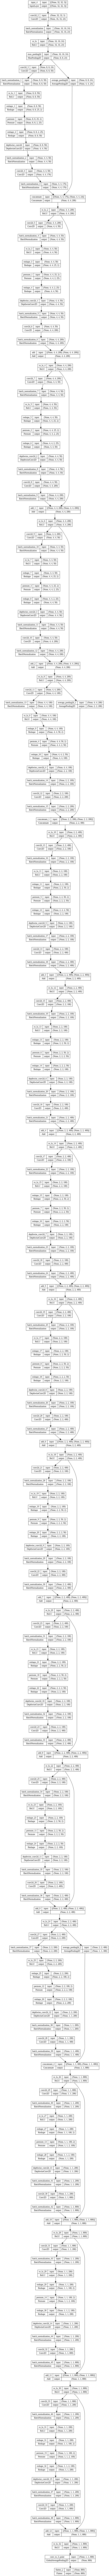

In [ ]:
plot_model(point_3_model, show_shapes=True)

In [ ]:
x_new_train = point_3_model.predict(x_train)

1563/1563 [==============================] - 35s 15ms/step


In [ ]:
x_new_train.shape

(50000, 800)

In [ ]:
x_new_test = point_3_model.predict(x_test)

313/313 [==============================] - 4s 14ms/step


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
pca.fit(x_new_train)

PCA(n_components=20)

In [ ]:
x_new_train = pca.transform(x_new_train)

In [ ]:
x_new_test = pca.transform(x_new_test)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor#example
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor#exampe
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import HuberRegressor, BayesianRidge, RANSACRegressor, SGDRegressor
from sklearn.svm import LinearSVR
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler, QuantileTransformer
from sklearn.cluster import KMeans

In [ ]:
ef supervised_models_classification(X_train, y_train,X_test, y_test):

  model_KNN = KNeighborsClassifier()
  model_DT  = DecisionTreeClassifier(random_state=0)
  model_B   = BaggingClassifier(random_state=0)
  model_RF  = RandomForestClassifier(random_state=0)
  model_AB  = AdaBoostClassifier(random_state=0)
  model_SVM = SVC(random_state=0)
  model_ET  = ExtraTreesClassifier(random_state=0)
  model_LR  = LogisticRegression(random_state=0, max_iter=200)
  model_GB  = GradientBoostingClassifier(random_state=0)
  model_QDA = QuadraticDiscriminantAnalysis()
  model_LDA = LinearDiscriminantAnalysis()
  model_GNB = GaussianNB()
  #Train
  model_KNN.fit(X_train, y_train)
  model_DT.fit(X_train, y_train)
  model_B.fit(X_train, y_train)
  model_RF.fit(X_train, y_train)
  model_AB.fit(X_train, y_train)
  model_SVM.fit(X_train, y_train)
  model_ET.fit(X_train, y_train)
  model_LR.fit(X_train, y_train)
  model_GB.fit(X_train, y_train)
  model_QDA.fit(X_train, y_train)
  model_LDA.fit(X_train, y_train)
  model_GNB.fit(X_train, y_train)
  #Scores
  print("KNN, Exactitud: ", model_KNN.score(X_test, y_test))
  print("DT, Exactitud: ", model_DT.score(X_test, y_test))
  print("B, Exactitud: ",  model_B.score(X_test, y_test))
  print("RF, Exactitud: ", model_RF.score(X_test, y_test))
  print("AB, Exactitud: ", model_AB.score(X_test, y_test))
  print("SVM, Exactitud: ",model_SVM.score(X_test, y_test))
  print("ET, Exactitud: ", model_ET.score(X_test, y_test))
  print("LR, Exactitud: ", model_LR.score(X_test, y_test))
  print("GB, Exactitud: ", model_GB.score(X_test, y_test))
  print("QDA, Exactitud: ",model_QDA.score(X_test, y_test))
  print("LDA, Exactitud: ",model_LDA.score(X_test, y_test))
  print("GNB, Exactitud: ",model_GNB.score(X_test, y_test))

In [ ]:
y_train_new=y_train.numpy()

y_train_new= y_train_new.reshape((y_train_new.shape[0], 10))

y_train_new = np.argmax(y_train_new, axis=1)

In [ ]:
y_test_new=y_test.numpy()

y_test_new= y_test_new.reshape((y_test_new.shape[0], 10))

y_test_new = np.argmax(y_test_new, axis=1)

In [ ]:
supervised_models_classification(x_new_train, y_train_new,x_new_test, y_test_new)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


KNN, Exactitud:  0.1525
DT, Exactitud:  0.1323
AB, Exactitud:  0.1805
SVM, Exactitud:  0.128
ET, Exactitud:  0.192
LR, Exactitud:  0.1315
GB, Exactitud:  0.196
QDA, Exactitud:  0.1271
LDA, Exactitud:  0.1321
GNB, Exactitud:  0.1276
